In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [7]:
url = r"C:\Users\seksatta\Desktop\masterlist.xlsx"

In [8]:
df = pd.read_excel(url, skiprows=6, 
                  parse_dates=True)


In [9]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.lower().str.replace("\n","  ")
df.columns = df.columns.str.lower().str.replace(r' ','_')

In [10]:
df['error_code'] = df['problem'].str.extract(r'(\b[A-Z]\d{1})(?<!-)')


# Cleaning up date

อันนี้ดีเอาไว้ check ได้

In [11]:
df.rename(columns = {'parts__and_cover_page__received_date':'received_date'}, inplace = True)

In [12]:
def check_date_format(date_str):
    try:
        pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')
        return True
    except ValueError:
        return False

In [13]:
df['received_date'] = df['received_date'].apply(lambda x: np.nan if x == '-' else x)

In [14]:
invalid_dates = df[~df['received_date'].apply(check_date_format)]
print("Invalid dates:")
print(invalid_dates)

Invalid dates:
Empty DataFrame
Columns: [no., received_date, actual_received_parts, basic_investigate__received_date, plan_to_finished_basic_investigation_date, plan__send__date, actual___send__date, plan_of_analysis_start_date, doc._no., production_date, installation_date, problem_date, part_name, drawing, supplier_name, problem, model, serial, model_type, model_group, customer, urgent, normal, initial, spare_parts, concern__big_problem, gib_no, status, eqg, mkg, mkg_cover__reply_date_, due_date_for_supplier__(ref._std__lt), plan_of_submit_report_to_mkg, report, final_report, date_of_remain_for_analysis__(ref._std__lt), control_analysis_lt__(ref._std__lt), lt__usage_workday, diff_from_due_date_(workday), checking_result___from_supplier_ok/ng, cause, part_ng, remark, error_code]
Index: []

[0 rows x 44 columns]


 Change to str to datetime type

In [15]:
df['received_date'] = pd.to_datetime(df['received_date'] ,format = '%Y')

In [16]:
df['year'] = df['received_date'].dt.year
df['year'] = df['year'].fillna(0).astype(int)

In [17]:
df_pcb = df[df['part_name'].str.contains(r'\bPCB(?<!Thermistor)', case= False, regex=True)]
df_pcb.reset_index(inplace=True)


In [18]:
g = df_pcb.groupby('year')['mkg'].count()

Text(0, 0.5, 'qty of failure [pcs]')

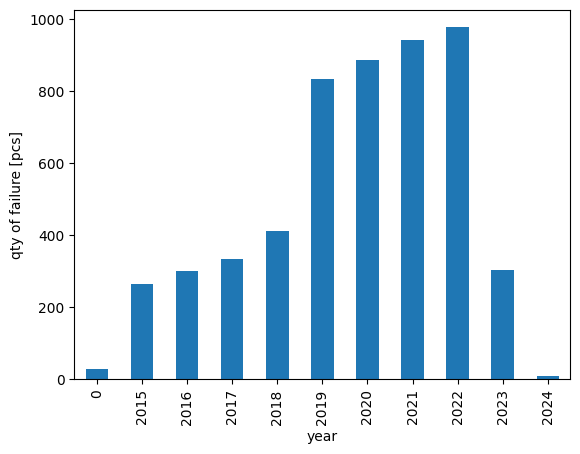

In [19]:
g.plot(kind='bar');
plt.ylabel("qty of failure [pcs]")

In [20]:
g1 = df_pcb.groupby(['year','error_code'])['mkg'].count().reset_index()

In [21]:
def get_top_5(group):
    return group.nlargest(5, 'mkg')


In [22]:
top_5_each_year = g1.groupby('year').apply(get_top_5).reset_index(drop=True)


C:\Users\seksatta\AppData\Local\Temp\ipykernel_21328\3711007168.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_each_year = g1.groupby('year').apply(get_top_5).reset_index(drop=True)


In [23]:
pivot_df = top_5_each_year.pivot(index='year', columns='error_code', values='mkg').fillna(0)


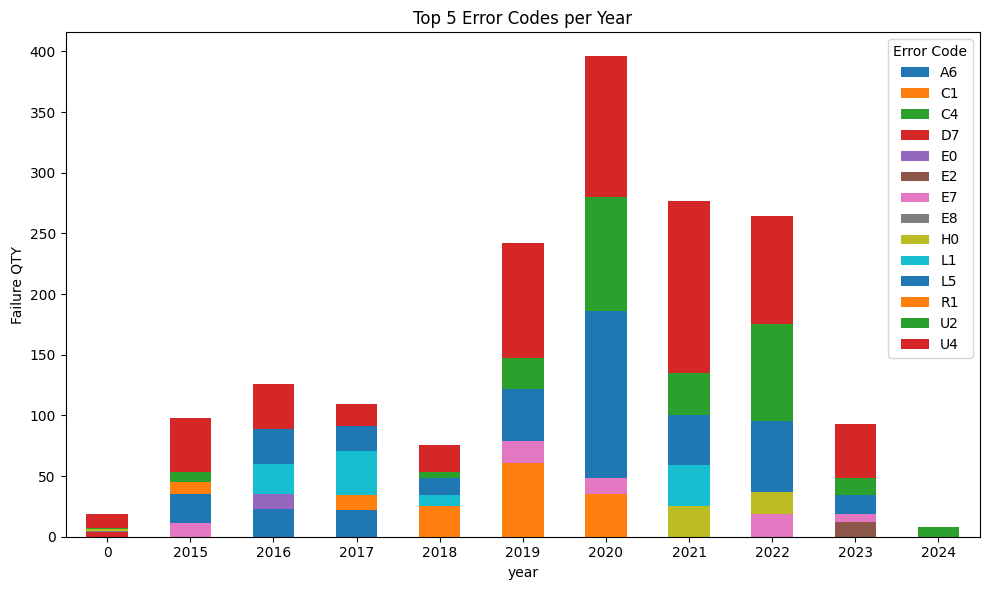

In [160]:
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the plot

plt.ylabel('Failure QTY')
plt.title('Top 5 Error Codes per Year')
plt.legend(title='Error Code')
plt.xticks(rotation=0)
plt.tight_layout()

In [25]:
try:
    # Replace 'model_dit.db' with the correct path to your database file
    with sqlite3.connect('model_dit.db') as conn:
        # SQL command to select all data from the dit_model table
        sql_comd = "SELECT * FROM dit_model"
        
        # Execute the SQL command and read the data into a pandas DataFrame
        df3 = pd.read_sql_query(sql_comd, conn)
        
        # Display the first few rows of the DataFrame
       

except Exception as e:
    print(f"An error occurred: {e}")

## Left join between df_pcb and df3 

In [35]:
df3.rename(columns = {'model_name':'model'}, inplace=True)

In [47]:
df_pcb.columns

Index(['index', 'no.', 'received_date', 'actual_received_parts',
       'basic_investigate__received_date',
       'plan_to_finished_basic_investigation_date', 'plan__send__date',
       'actual___send__date', 'plan_of_analysis_start_date', 'doc._no.',
       'production_date', 'installation_date', 'problem_date', 'part_name',
       'drawing', 'supplier_name', 'problem', 'model', 'serial', 'model_type',
       'model_group', 'customer', 'urgent', 'normal', 'initial', 'spare_parts',
       'concern__big_problem', 'gib_no', 'status', 'eqg', 'mkg',
       'mkg_cover__reply_date_', 'due_date_for_supplier__(ref._std__lt)',
       'plan_of_submit_report_to_mkg', 'report', 'final_report',
       'date_of_remain_for_analysis__(ref._std__lt)',
       'control_analysis_lt__(ref._std__lt)', 'lt__usage_workday',
       'diff_from_due_date_(workday)', 'checking_result___from_supplier_ok/ng',
       'cause', 'part_ng', 'remark', 'error_code', 'year', 'base_model',
       'group'],
      dtype='obje

In [38]:
df_pcb = df_pcb.merge(df3, on='model', how='left')

In [67]:
g4 = df_pcb.groupby(['year','group']).size().reset_index(name='count')

In [80]:
years = g4['year'].unique()


In [179]:
color_mapping = {
    'RA': 'red',
    'VRV': 'green',
    'SKY': 'blue',
    '': 'gray'  # Default color for groups without a specified color
}

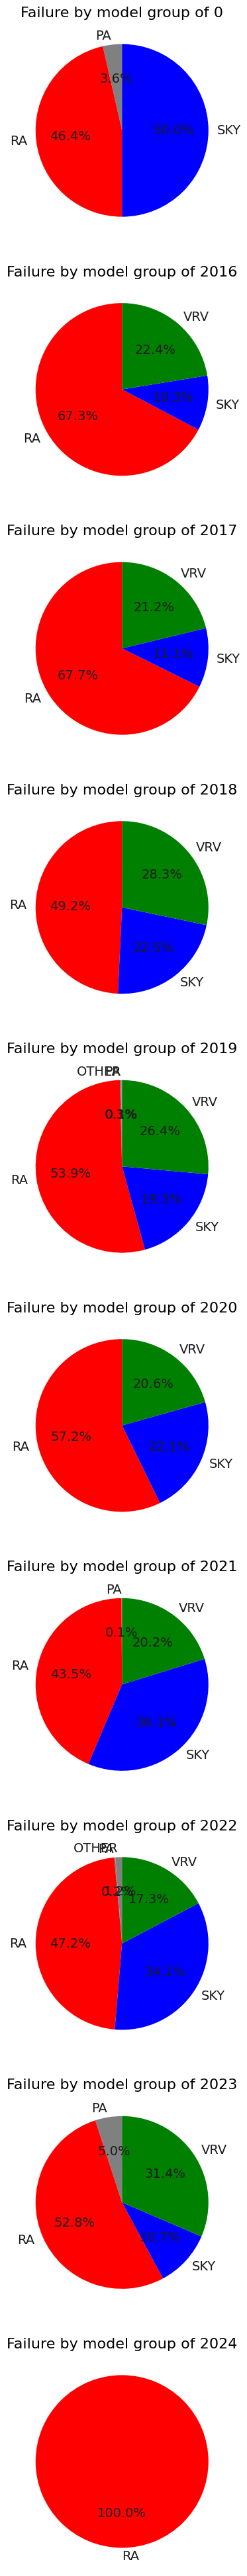

In [195]:
fig, axes = plt.subplots(years.size,1 ,  figsize=(5,5 *years.size))
for i, year in enumerate(years):
    ax = axes[i]
    data = g4[g4['year'] == year]
    colors = [color_mapping.get(group, 'gray') for group in data['group']]
    wedges, texts, autotexts = ax.pie(data['count'], labels=data['group'], colors=colors, autopct='%1.1f%%', startangle=90, textprops=dict(color=".1"))
    
    # Customize the text properties
    for text in texts:
        text.set_fontsize(14)
    for autotext in autotexts:
        autotext.set_fontsize(14)
    
    ax.set_title(f'Failure by model group of {year}', fontsize=16)
    
   
    

## Ant & lizard

In [158]:
df_pcb['cause'].fillna('', inplace=True)
ant_filter = df_pcb['cause'].str.contains(r'[aA]nt', regex=True)
lizard_filter = df_pcb['cause'].str.contains(r'[lL]izard', regex=True)

df_ant = df_pcb[ant_filter][['year', 'base_model', 'group']]
df_lizard = df_pcb[lizard_filter][['year', 'base_model', 'group']]
g_ant = df_ant.groupby(['group', 'base_model'])['year'].size()
g_lizard = df_lizard.groupby(['group', 'base_model'])['year'].size()

### Lizard

In [156]:
g_lizard

group  base_model
RA     BML-C          1
       BMS           18
       GBS            5
       GSI           14
       SF2           20
       SMS            9
SKY    BML-C         31
       SF2            4
       ZEAS7         33
VRV    VRV4-A         1
Name: year, dtype: int64

### Ant

In [157]:
g_ant

group  base_model
RA     BMS           8
       GSI           5
       SF2           5
SKY    BML-C         4
       ZEAS7         2
Name: year, dtype: int64

In [162]:
df_ant

,year,base_model,group
613,2017,NaN,NaN
893,2017,BMS,RA
1258,2018,ZEAS7,SKY
1752,2019,BMS,RA
2093,2019,SF2,RA
2260,2019,NaN,NaN
2276,2020,GSI,RA
2350,2020,BMS,RA
2365,2020,GSI,RA
2415,2020,BMS,RA


<Axes: ylabel='count'>

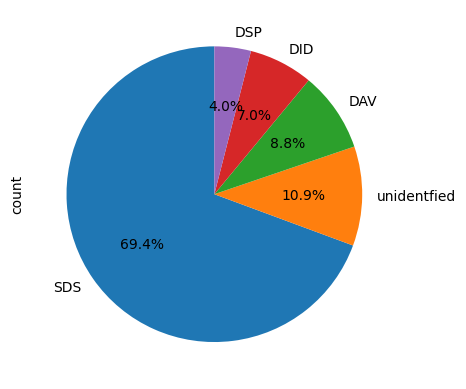

In [198]:
df_pcb['customer'] = df_pcb['customer'].str.replace(r'-','UNIDENTIFIED')
df_pcb.loc[:,'customer'].value_counts().head(5).plot(kind='pie', startangle=90, 
                                                    autopct = '%1.1f%%')

In [199]:
df_pcb.loc[:,'customer'].value_counts().head(5)

customer
SDS            3339
unidentfied     523
DAV             422
DID             338
DSP             192
Name: count, dtype: int64